# Examples of usage

In [23]:
%autoreload
import codebase
from codebase.data_generation import *
from codebase.sparse_regression import *
from codebase.utils import *

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
dataset = CountryDataset()

## Simple fitting

In [7]:
x = dataset.cumulative('France', rescaling=1000)

m2, m1 = make_targets(x.reshape(-1, 1))

augmented, _ = make_polynomials(m1, max_degree=3)

weights, _ = sparse_regression(augmented, m2, cutoff=1e-10)

show_weights(weights)

| function   |    $x_{k+1}$ |
|:-----------|-------------:|
| $1$        |  0.0537954   |
| $ x$       |  1.13167     |
| $ x^2$     | -0.000636907 |
| $ x^3$     | -6.35146e-07 |

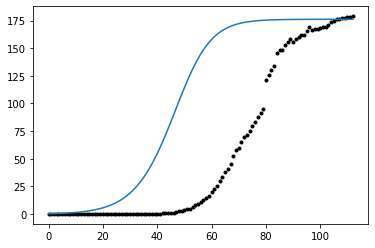

In [9]:
t = range(len(x))

guess = integrate(weights, [0.1], t)

plt.plot(x, 'k.')
plt.plot(guess)

## DF fitting

In [6]:
data = dataset.ox_augmented()

m2, m1 = make_targets_df(data)
different = m1['ConfirmedCases'].reset_index(drop=True) != m2['ConfirmedCases'].reset_index(drop=True)
m2, m1 = m2.loc[different], m1.loc[different]
print('Train samples: ', len(m1.index))

Train samples:  7910


In [7]:
poly_args = {
    'variables': ['ConfirmedCases', 'StringencyIndexForDisplay', 'SH.MED.BEDS.ZS', 'SH.MED.PHYS.ZS', 'SP.POP.TOTL'],
    'time_dependent_variables': ['ConfirmedCases', 'StringencyIndexForDisplay'],
    'predicted_variables': ['ConfirmedCases'],
    'max_degree': 3
}


X, integration_args = make_polynomials_df(m1, **poly_args)

In [25]:
weights, _ =  sparse_regression(X.values, m2[poly_args['predicted_variables']].values, cutoff=1e-10)
integration_args['weights'] = weights
weights

<tf.Tensor: shape=(21, 1), dtype=float32, numpy=
array([[ 1.4317710e+00],
       [ 1.4837592e-07],
       [-8.1677246e-01],
       [-1.2883226e-02],
       [-3.8314691e-01],
       [-2.2228117e+00],
       [ 0.0000000e+00],
       [-8.7026092e-07],
       [ 1.1060908e-06],
       [-3.3965765e-07],
       [ 1.1838139e-06],
       [ 5.4761499e-01],
       [-2.3175746e-02],
       [ 2.8944224e-01],
       [ 3.0782580e-01],
       [ 2.0609950e-01],
       [-3.0290303e-01],
       [-3.8556929e+00],
       [-1.6119553e-02],
       [ 8.4761429e+00],
       [ 1.1267170e+00]], dtype=float32)>

### Cutoff plot

100%|█████████████| 40/40 [00:01<00:00, 20.62it/s]


[]

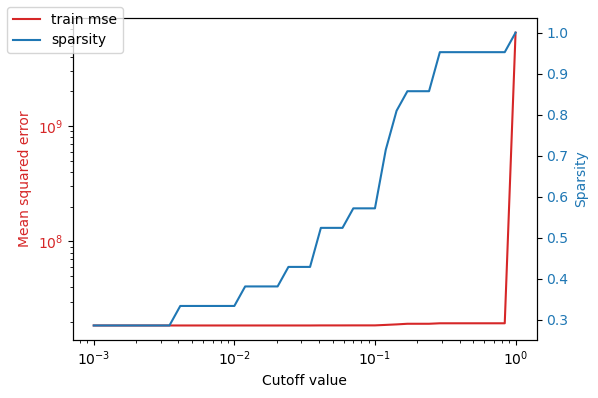

In [17]:
cutoffs = np.logspace(-3, 0, num=40)
sparsity = []
mses = []
all_weights = []

for k in tqdm(cutoffs, ncols=50):
    weights, _ = sparse_regression(X.values, m2[poly_args['predicted_variables']].values, cutoff=k)
    mse = ((tf.matmul(tf.cast(X.values, dtype=tf.float32), tf.cast(weights, dtype=tf.float32)) - m2[poly_args['predicted_variables']].values)**2).numpy().mean()
    mses.append(mse)
    sparsity.append((weights.numpy() == 0).sum()/len(weights.numpy().flatten()))
    all_weights.append(weights)

fig, ax1 = plt.subplots(dpi=100)

color = 'tab:red'
ax1.set_xlabel('Cutoff value')
ax1.set_ylabel('Mean squared error', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.plot(cutoffs, mses, color=color, label='train mse')
ax1.tick_params(axis='y')

handles, labels = ax1.get_legend_handles_labels()

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Sparsity', color=color)
ax2.plot(cutoffs, sparsity, color=color, label='sparsity')
ax2.set_xscale('log')
ax2.tick_params(axis='y', labelcolor=color)
handles2, labels2 = ax2.get_legend_handles_labels()
handles += handles2
labels += labels2

fig.legend(handles, labels, loc='upper left')

fig.tight_layout()
plt.plot()
# plt.savefig('sparsity_vs_mse.png', dpi=100)


### Integration

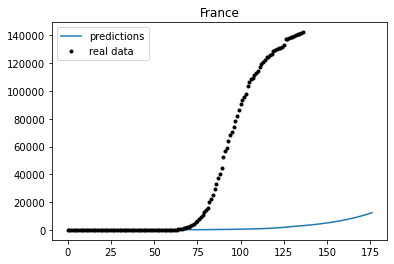

In [27]:
country = 'France'

country_data = data[data['CountryName'] == country]
t = range(len(country_data.index) + (extrapolation:=40))
high_data = data[(data['CountryName'] == country) & (data['ConfirmedCases'] > 50)]
real_t = len(high_data.index)
guess = integrate_df(real_trajectory=high_data, extrapolation=extrapolation, **integration_args, **poly_args)
plt.plot(t[-real_t-extrapolation:], guess[:, 0], label='predictions')
plt.plot(t[:-extrapolation], country_data['ConfirmedCases'], 'k.', label='real data')
plt.legend()
plt.title(country)
plt.show()